In [43]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Load the provided datasets
df2021 = pd.read_csv('..\\data\\daily-shelter-overnight-service-occupancy-capacity-2021.csv')
df2022 = pd.read_csv('..\\data\\daily-shelter-overnight-service-occupancy-capacity-2022.csv')
df2023 = pd.read_csv('..\\data\\daily_shelter_overnight_occupancy.csv')

df2022['OCCUPANCY_DATE'] = pd.to_datetime(df2022['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')
df2021['OCCUPANCY_DATE'] = pd.to_datetime(df2021['OCCUPANCY_DATE'], format='%y-%m-%d').dt.strftime('%Y-%m-%d')

# Combine the datasets for 2021 and 2022
df = pd.concat([df2021, df2022])

# Ensure OCCUPANCY_DATE is in datetime format
df['OCCUPANCY_DATE'] = pd.to_datetime(df['OCCUPANCY_DATE'])

# Filter the DataFrame for entries in the years 2021 and 2022
df_2021_2022 = df[df['OCCUPANCY_DATE'].dt.year.isin([2021, 2022])]

# Group by LOCATION_ID and year, then count unique months for each group
monthly_data_count = df_2021_2022.groupby(['LOCATION_ID', df_2021_2022['OCCUPANCY_DATE'].dt.year])['OCCUPANCY_DATE'].apply(lambda x: x.dt.month.nunique()).reset_index(name='unique_month_count')

# Identify LOCATION_IDs that have less than 12 unique months of data in either year
location_ids_with_insufficient_data = monthly_data_count[(monthly_data_count['unique_month_count'] < 12)].groupby('LOCATION_ID')['LOCATION_ID'].unique().apply(list).sum()

# Filter the original DataFrame to exclude these LOCATION_IDs
df = df[~df['LOCATION_ID'].isin(location_ids_with_insufficient_data)]

# Additionally, filter out shelters that do not have data in 2023
# Assuming df2023 is your DataFrame for 2023
df2023['OCCUPANCY_DATE'] = pd.to_datetime(df2023['OCCUPANCY_DATE'])
location_ids_2023 = df2023['LOCATION_ID'].unique()
df = df[df['LOCATION_ID'].isin(location_ids_2023)]

# Grouping by OCCUPANCY_DATE and LOCATION_ID to find the max SERVICE_USER_COUNT for each location per day
max_service_users_per_day = df.groupby(['OCCUPANCY_DATE', 'LOCATION_ID'])['SERVICE_USER_COUNT'].max().reset_index()

# Filtering out locations with a max SERVICE_USER_COUNT < 20 for each day
filtered_max_service_users = max_service_users_per_day[max_service_users_per_day['SERVICE_USER_COUNT'] >= 30]

# Merging the filtered data back with the original df to retain only the relevant entries
df_filtered = df.merge(filtered_max_service_users, on=['OCCUPANCY_DATE', 'LOCATION_ID', 'SERVICE_USER_COUNT'])

# Combine the datasets for 2021 and 2022
combined_df = pd.concat([df2021, df2022, df2023])

# # # Filter the original DataFrame to include only these LOCATION_IDs
combined_df = combined_df[combined_df['LOCATION_ID'].isin(location_ids_2023)]

# Filtering out shelters with max SERVICE_USER_COUNT < 20 for each day
combined_filtered_df = combined_df.groupby(['OCCUPANCY_DATE', 'LOCATION_ID']).agg({'SERVICE_USER_COUNT': 'max'}).reset_index()
combined_filtered_df = combined_filtered_df[combined_filtered_df.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].transform('max') >= 30]

# Re-aggregating the data after filtering
aggregated_overall_users = combined_filtered_df.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum()
aggregated_overall_users.index = pd.to_datetime(aggregated_overall_users.index, format='%Y-%m-%d')
aggregated_overall_users.sort_index(inplace=True)


In [45]:
def predict_per_location(location_id):
    location_id = int(location_id)
    df_location_id = df_filtered[df_filtered['LOCATION_ID'] == location_id]

    # Aggregate the combined data by OCCUPANCY_DATE to get the total SERVICE_USER_COUNT for each date
    aggregated_overall_users = df_location_id.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum()

    # Convert the index to datetime format
    aggregated_overall_users.index = pd.to_datetime(aggregated_overall_users.index, format='%Y-%m-%d')
    aggregated_overall_users.sort_index(inplace=True)

    # Combine the datasets for 2021, 2022, 2023
    combined_location_id = combined_filtered_df[combined_filtered_df['LOCATION_ID'] == location_id]

    # Aggregate the combined data by OCCUPANCY_DATE to get the total SERVICE_USER_COUNT for each date
    aggregated_overall_users_all_years = combined_location_id.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum()

    # Convert the index to datetime format
    aggregated_overall_users_all_years.index = pd.to_datetime(aggregated_overall_users_all_years.index, format='%Y-%m-%d')
    aggregated_overall_users_all_years.sort_index(inplace=True)

    # Define a SARIMA model for the aggregated time series data
    # The order parameter specifies the AR, differencing, and MA terms, respectively.
    # The seasonal_order parameter adds seasonal terms with a weekly periodicity (specified as 7).
    model_overall_users = SARIMAX(aggregated_overall_users, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Weekly seasonality assumed

    # Fit the SARIMA model to the data.
    # The disp=False argument suppresses convergence output for cleaner presentation.
    sarima_overall_users_result = model_overall_users.fit(disp=False)

    # Forecast the service users for the next 365 days (covering 2023).
    forecast_overall_users = sarima_overall_users_result.get_forecast(steps=365)

    # Extract the mean forecast values from the forecast results.
    mean_forecast_overall_users = forecast_overall_users.predicted_mean

    # Extract the confidence intervals for the forecast. 
    # This provides an upper and lower bound for the forecast, indicating the uncertainty.
    confidence_intervals_overall_users = forecast_overall_users.conf_int()

    # Set up the figure and axis for plotting with a specified size.
    plt.figure(figsize=(14, 7))

    # Plot the observed data in blue.
    plt.plot(aggregated_overall_users_all_years.index, aggregated_overall_users_all_years, label='Observed')

    # Plot the forecasted data in red.
    plt.plot(mean_forecast_overall_users.index, mean_forecast_overall_users, color='red', label='Forecast for 2023')

    # Fill the area between the upper and lower confidence intervals with pink to indicate uncertainty.
    plt.fill_between(confidence_intervals_overall_users.index, 
                    confidence_intervals_overall_users.iloc[:, 0], 
                    confidence_intervals_overall_users.iloc[:, 1], color='pink')
    
    # Add a legend to the plot for clarity.
    plt.legend()

    # Add a title to the plot.
    plt.title(f'SARIMA Forecast of Overall Service Users at Location {location_id}')

    # Display the plot.
    plt.show()

    return mean_forecast_overall_users

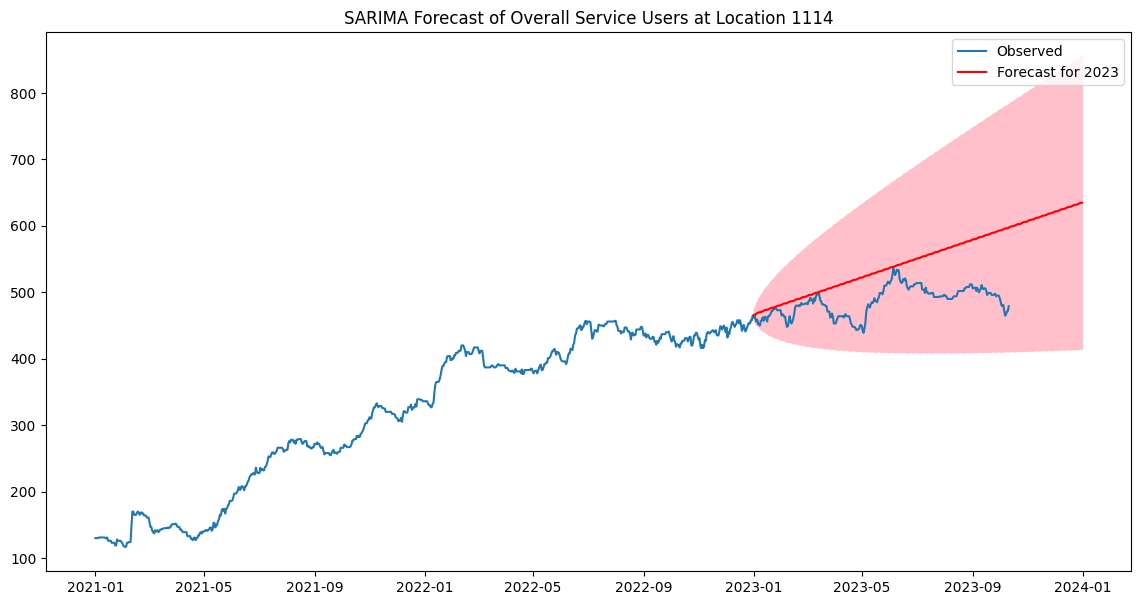

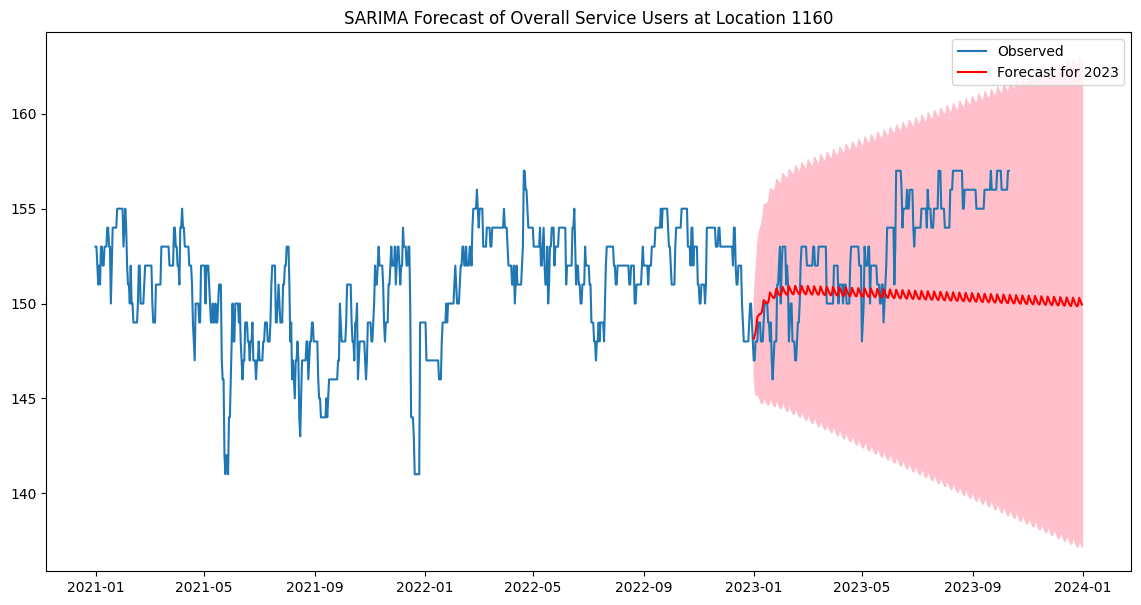

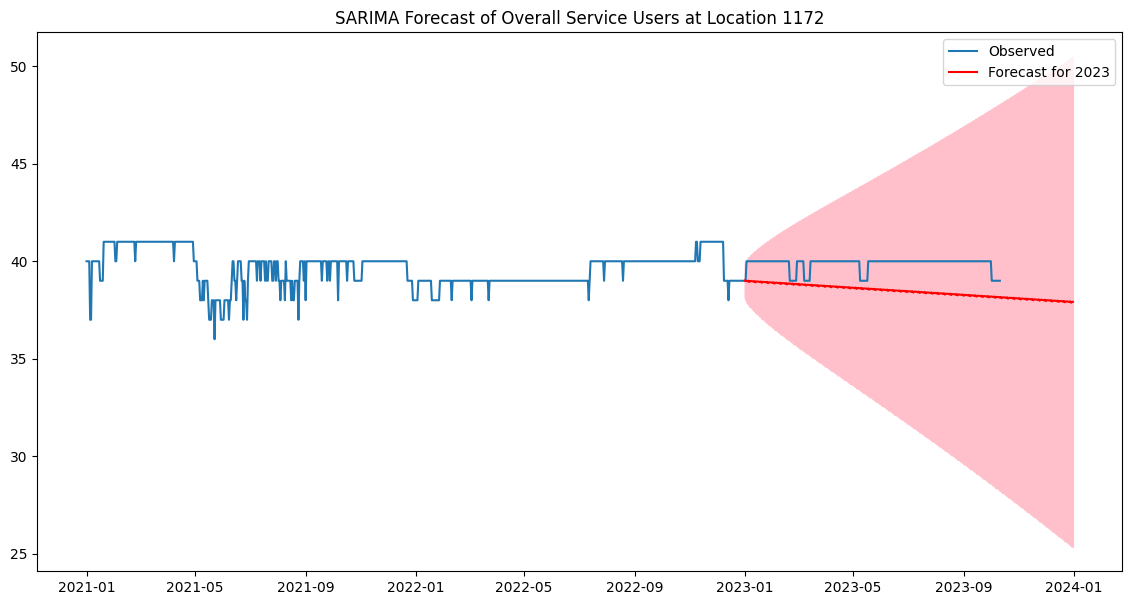

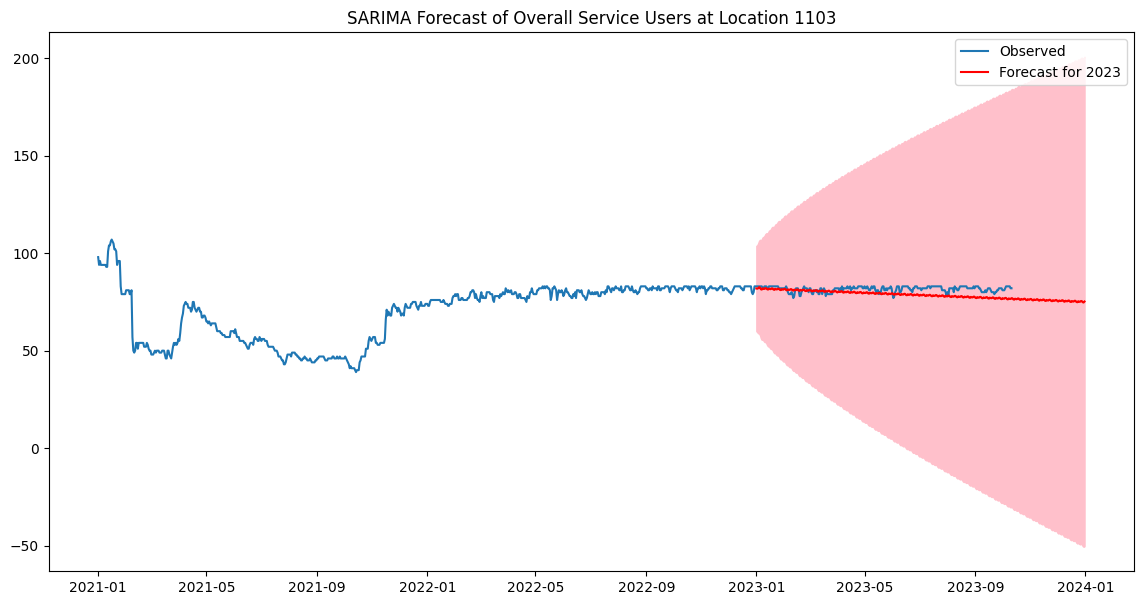

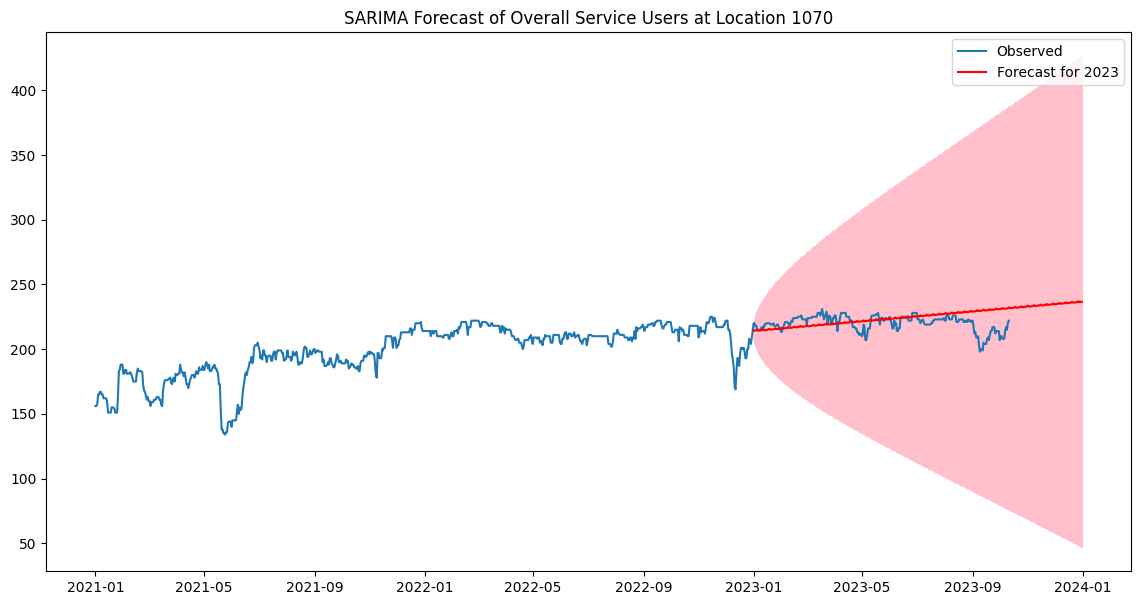

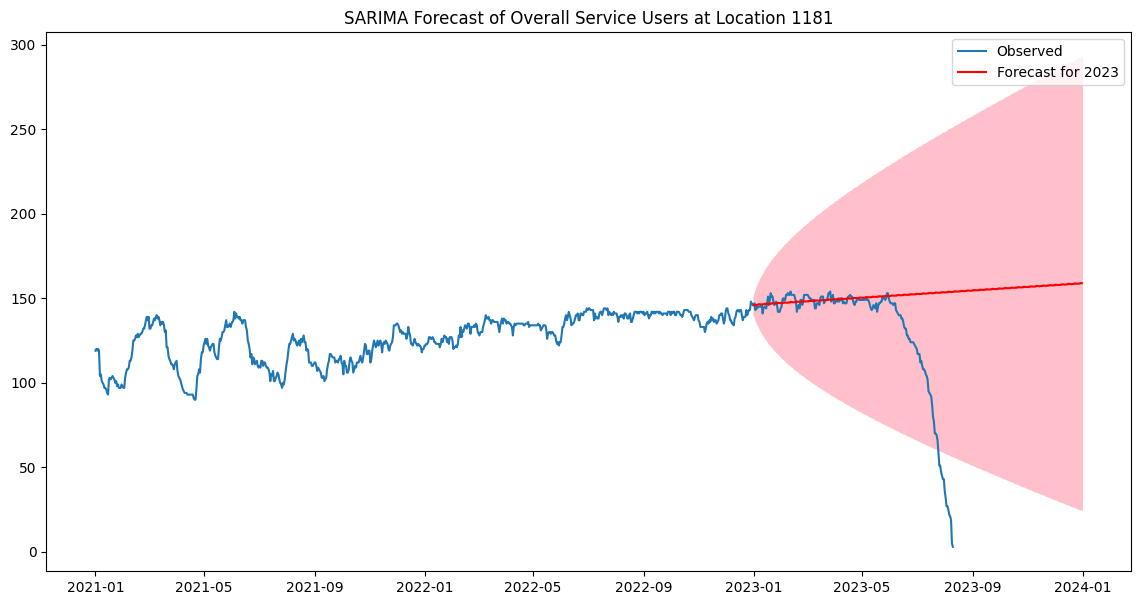

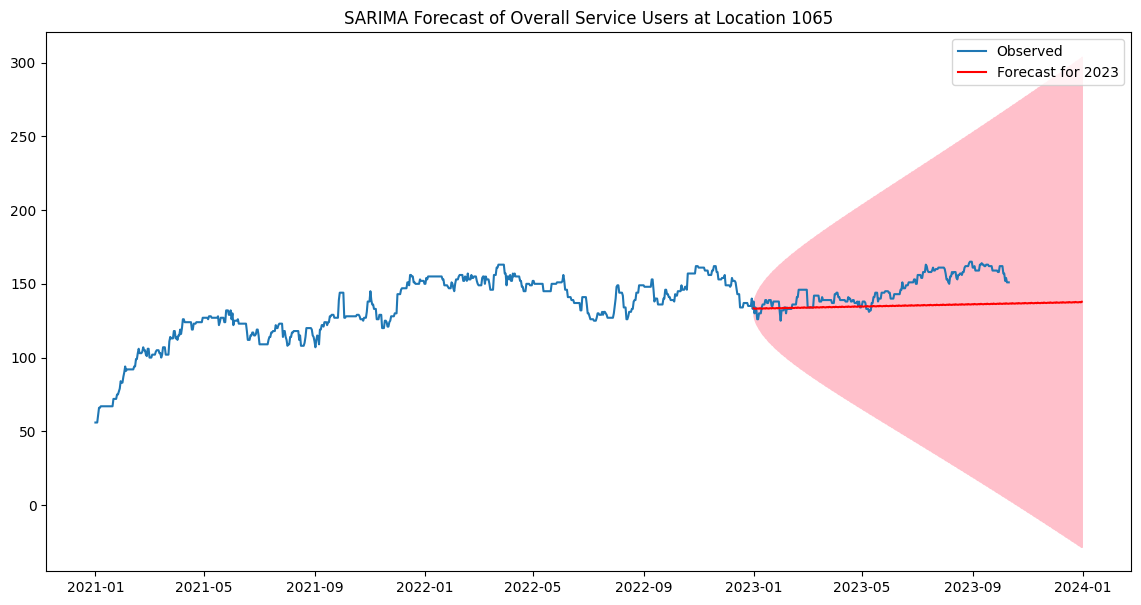

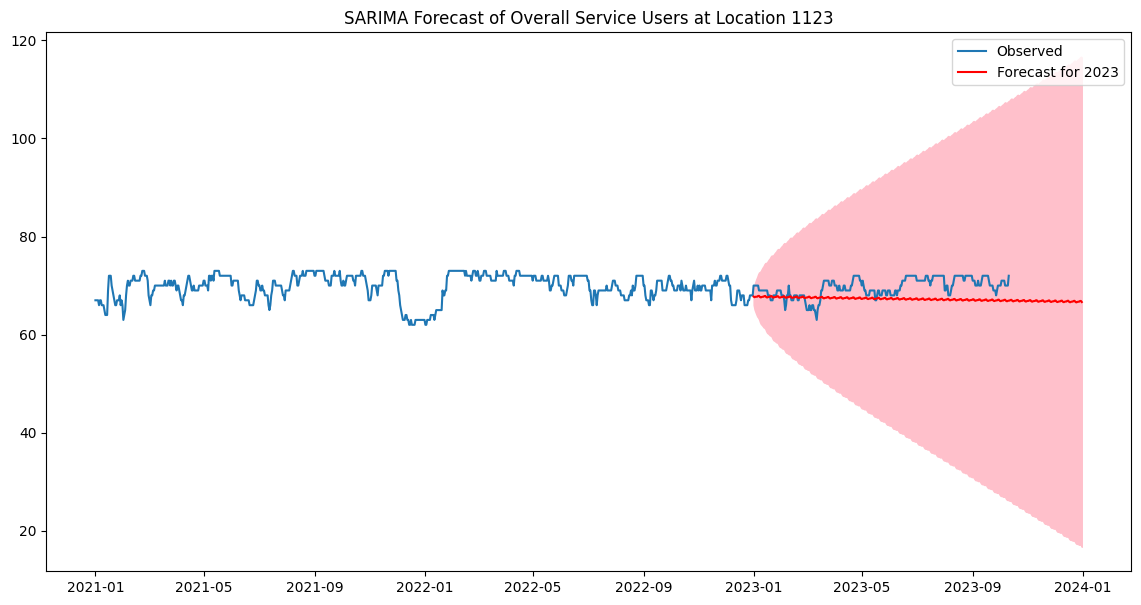

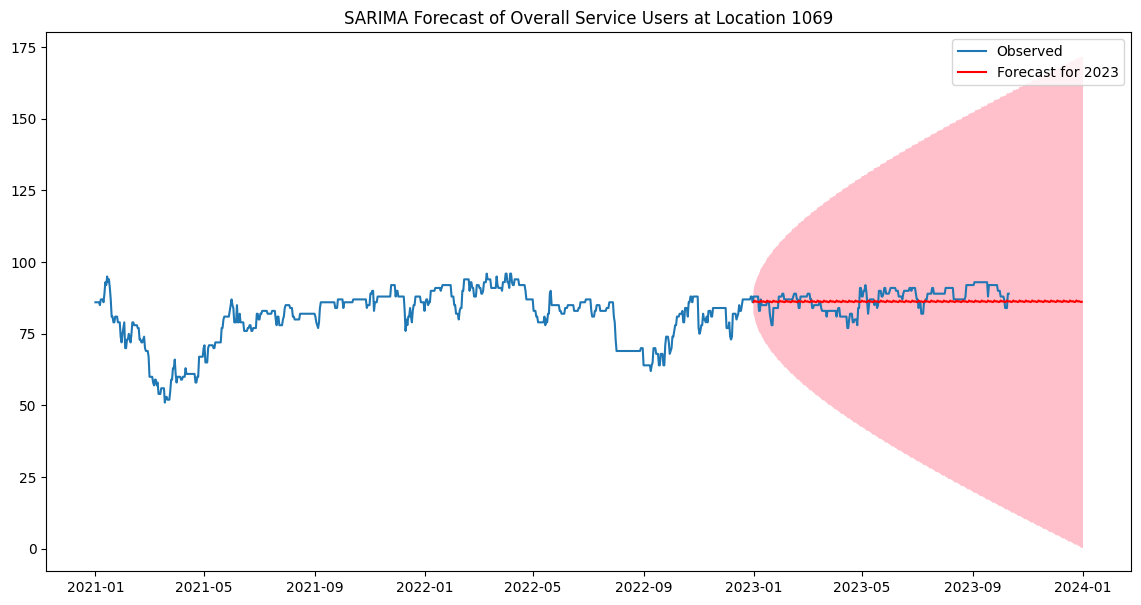

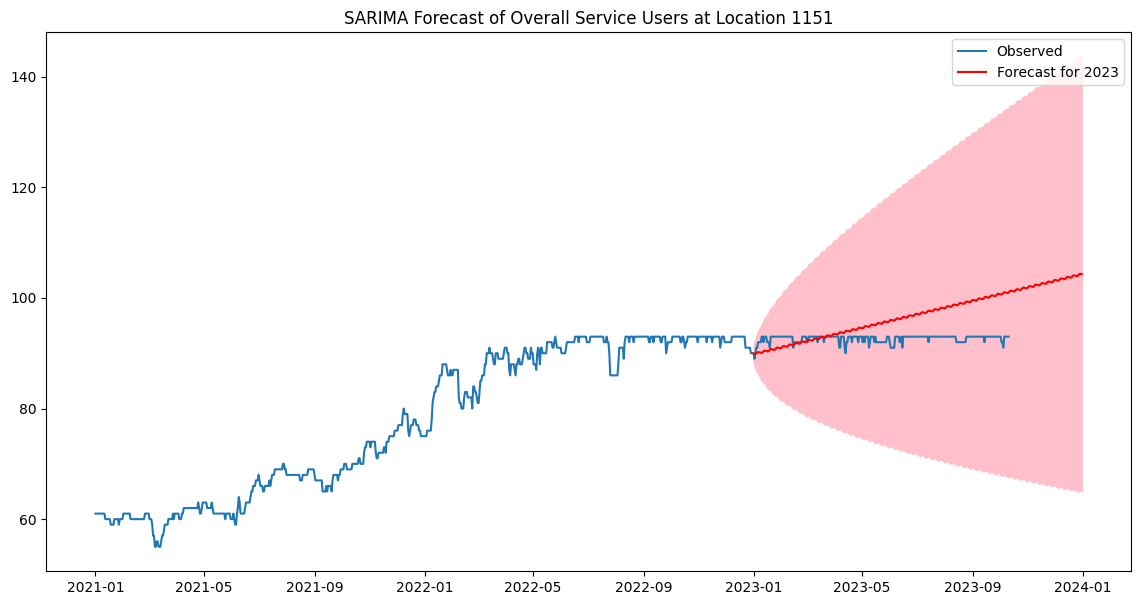

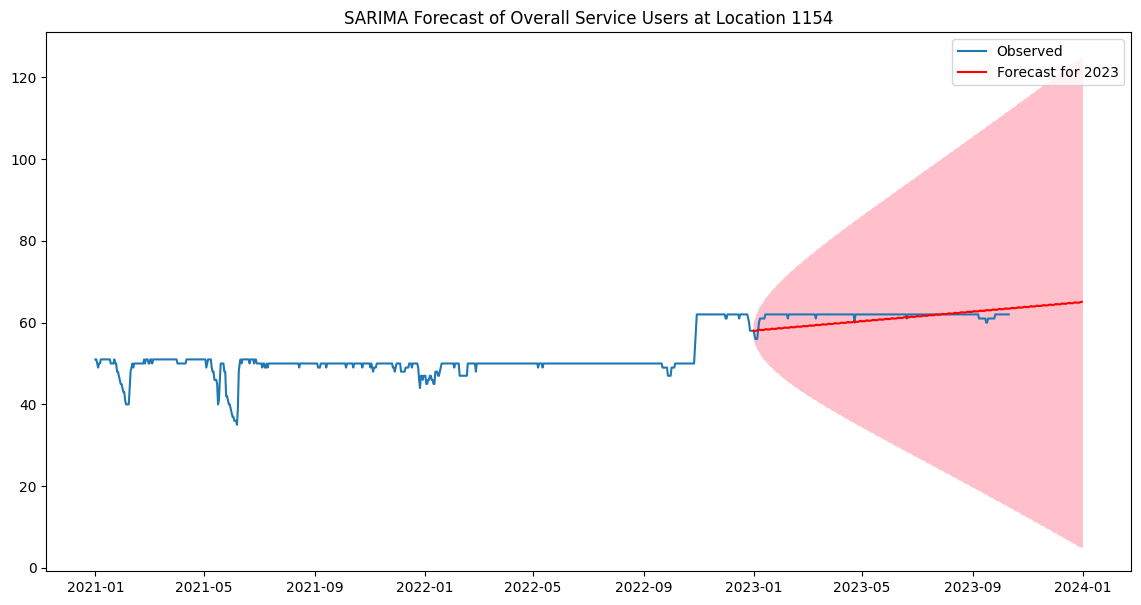

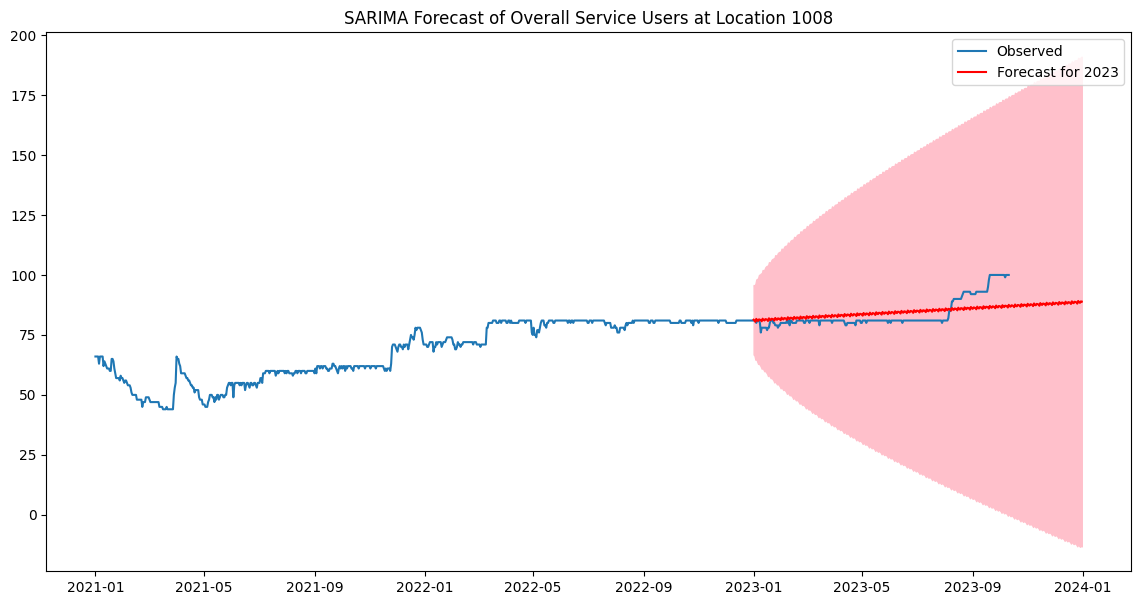

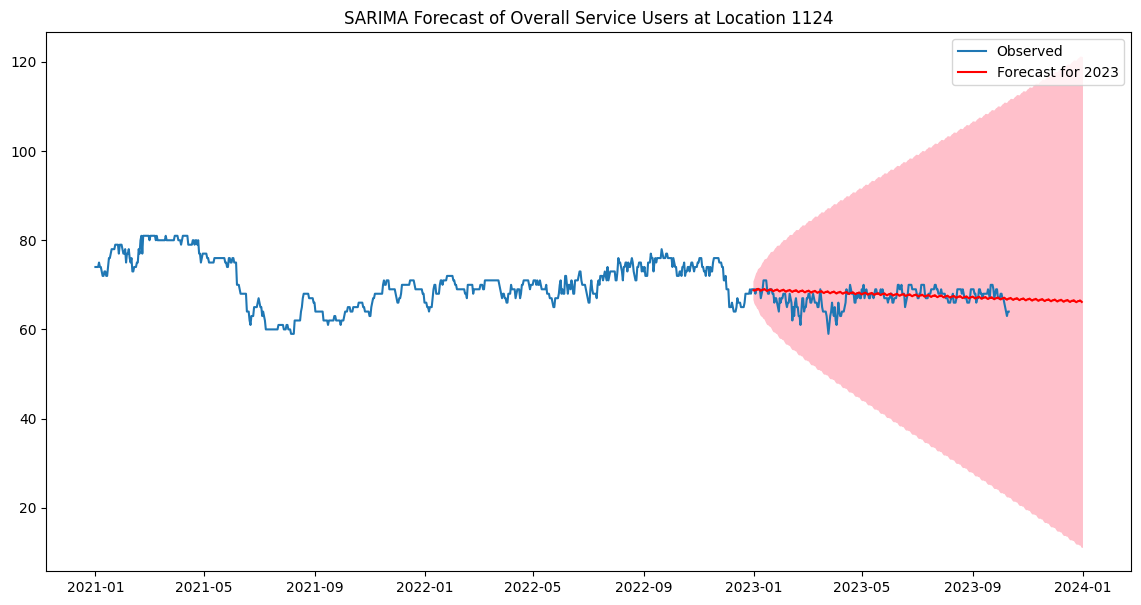

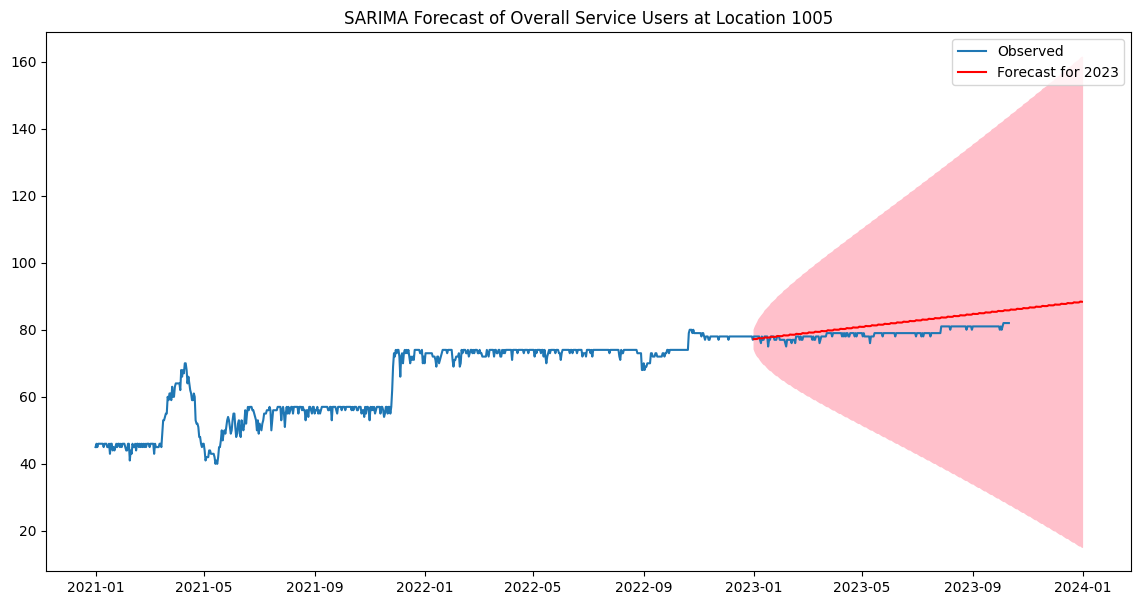

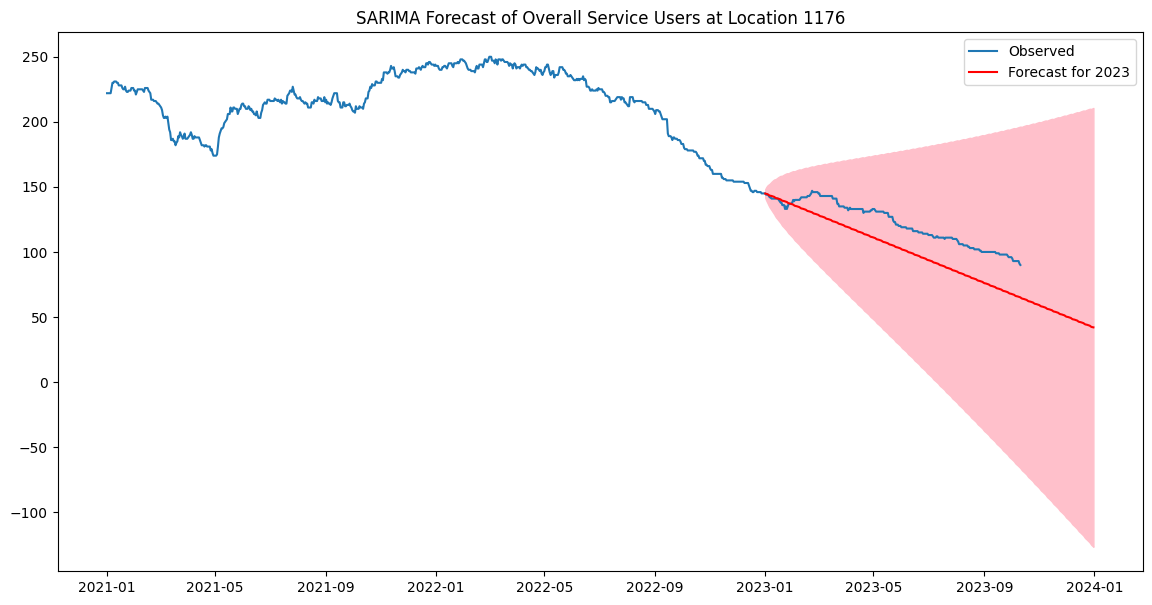

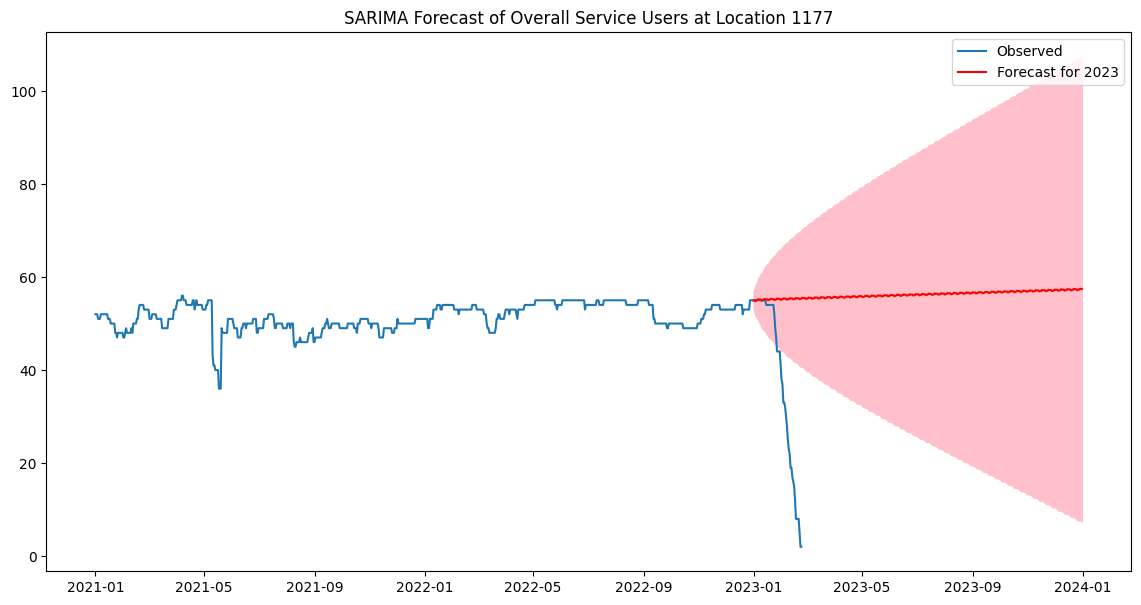

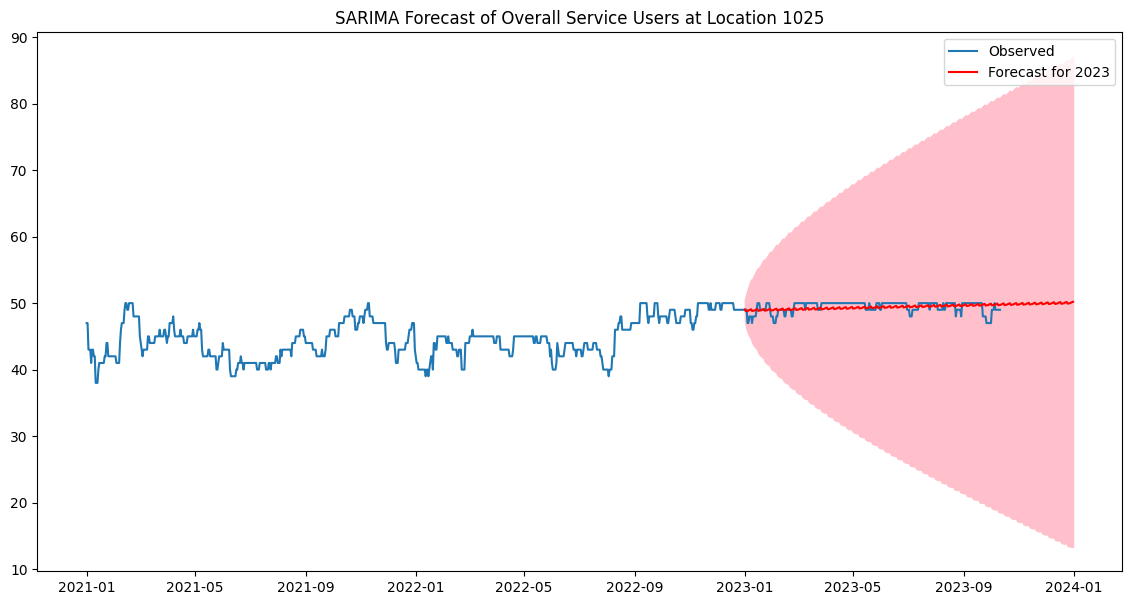

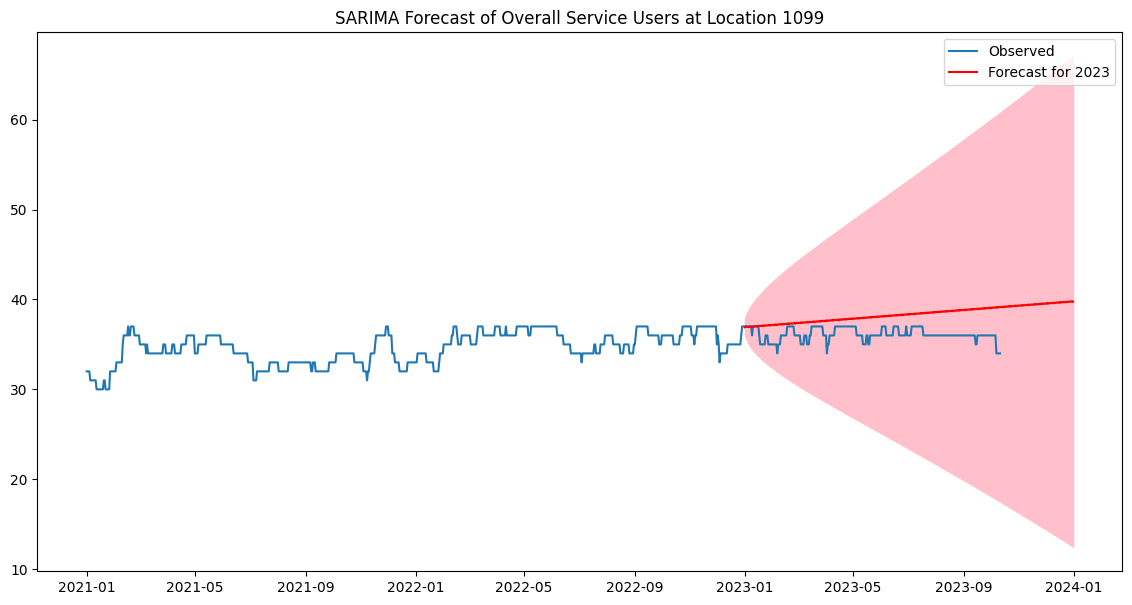

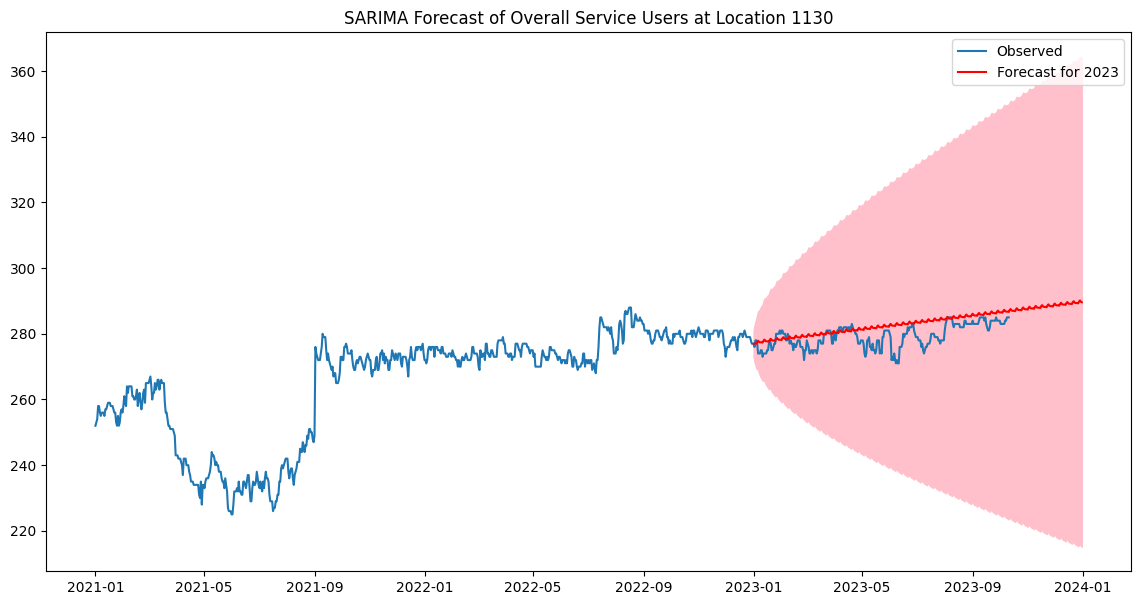

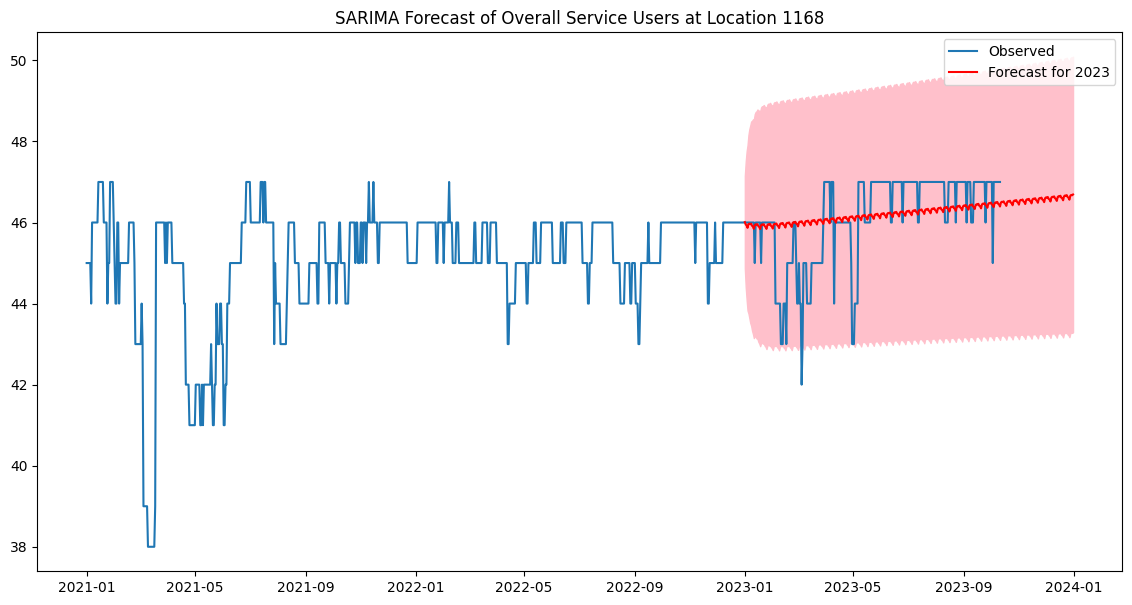

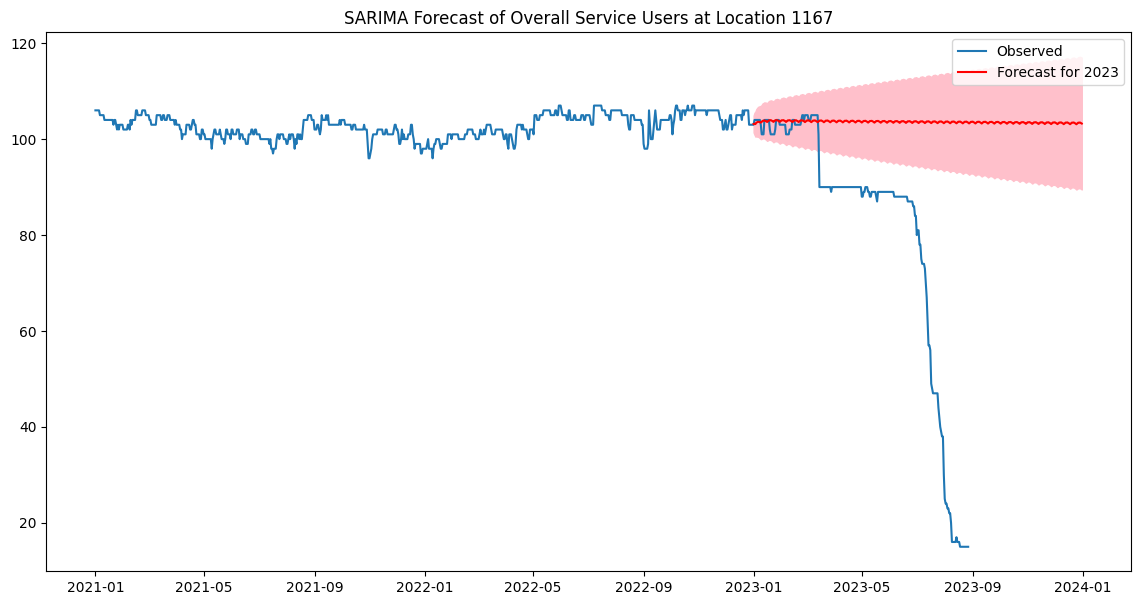

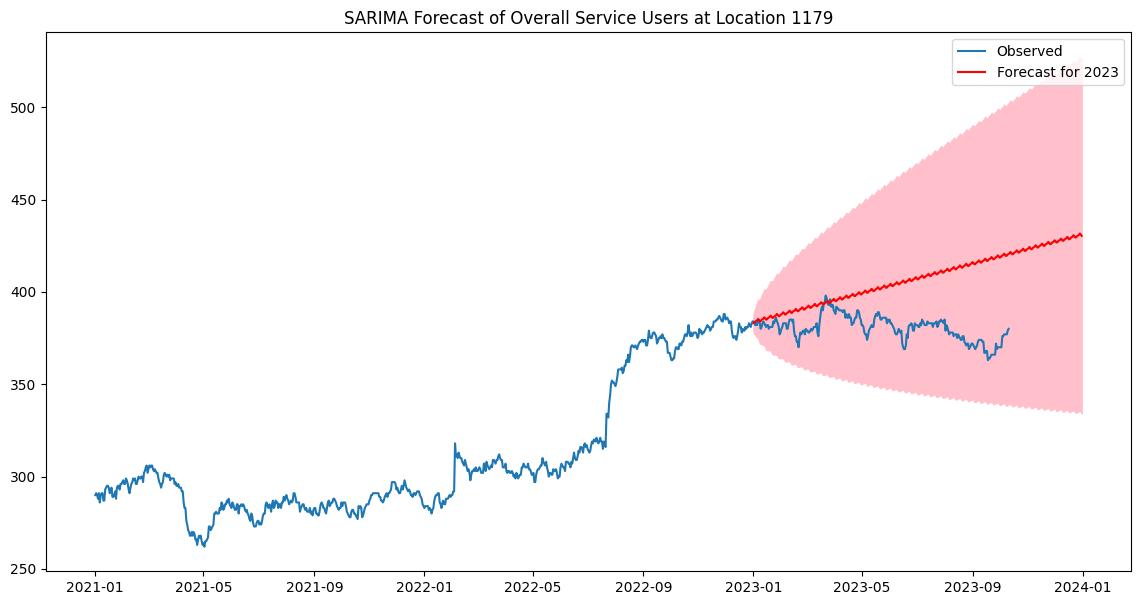

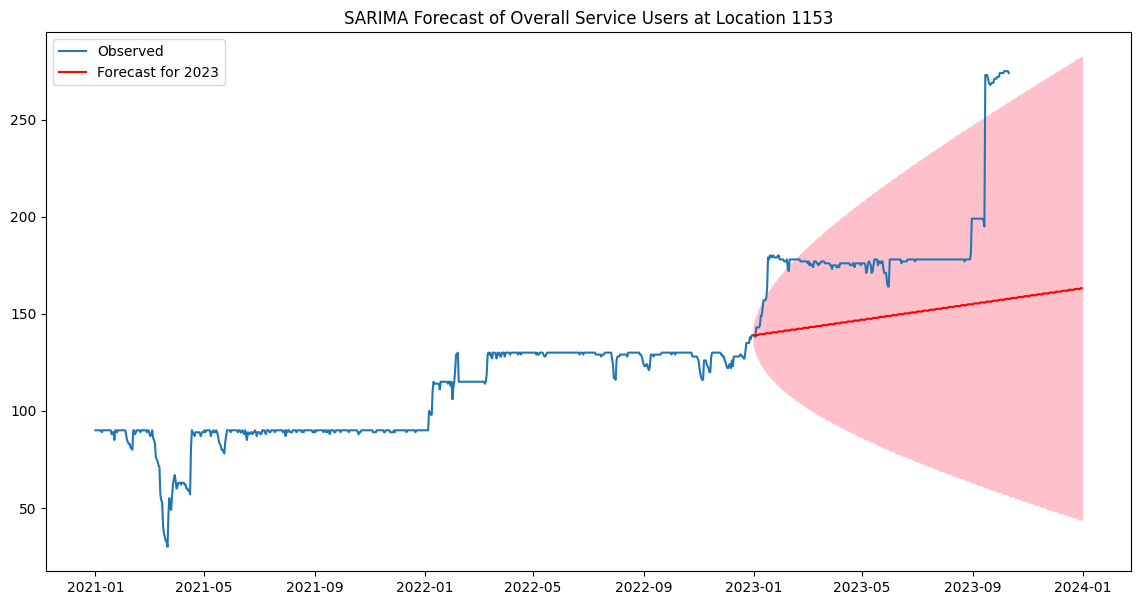

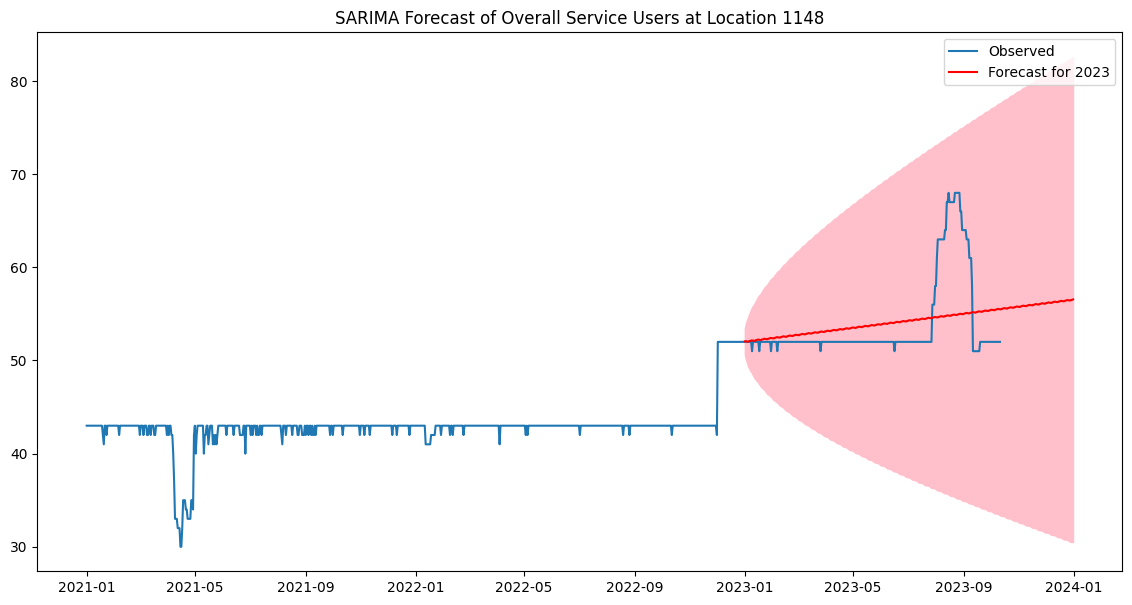

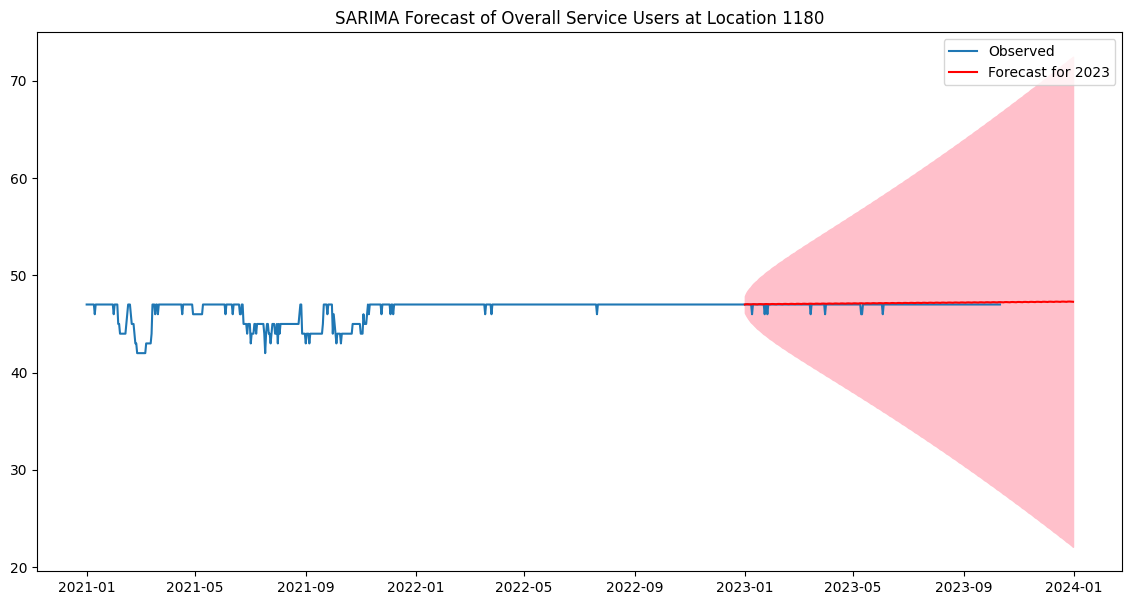

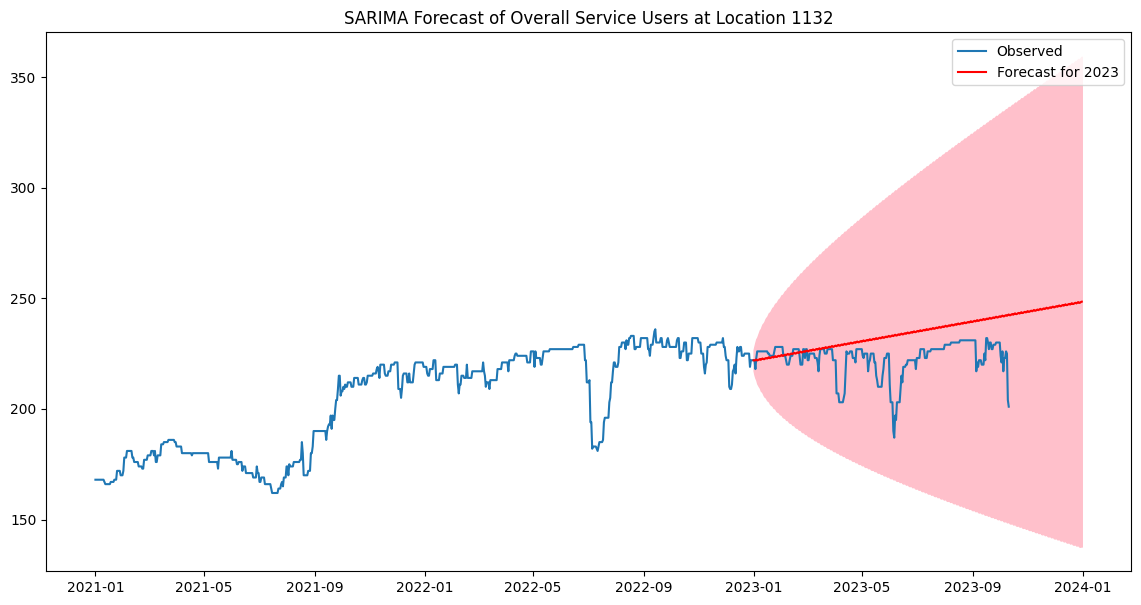

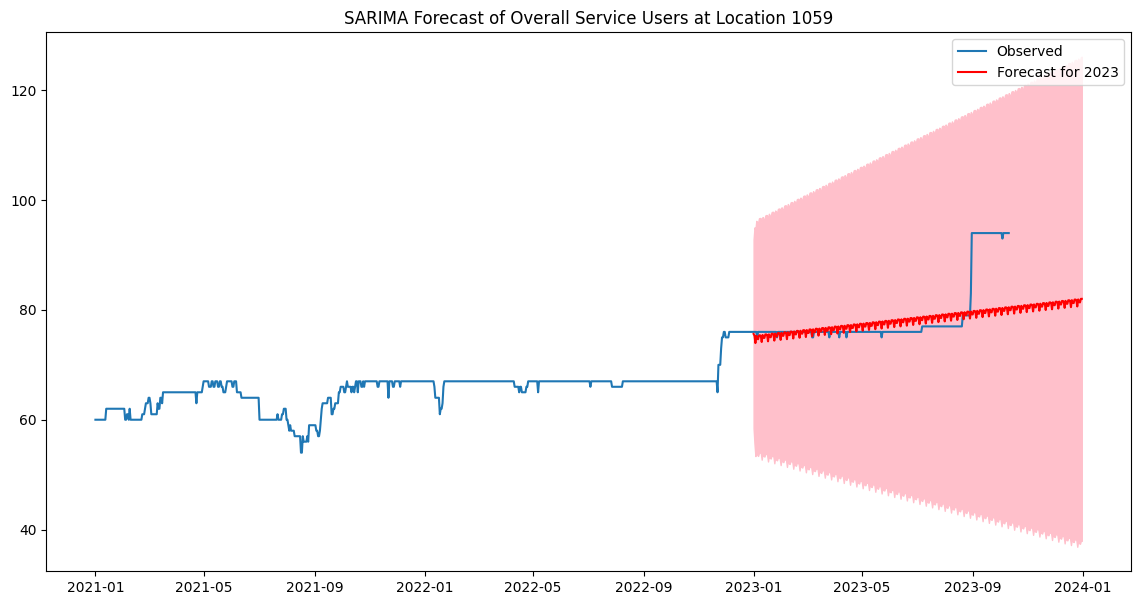

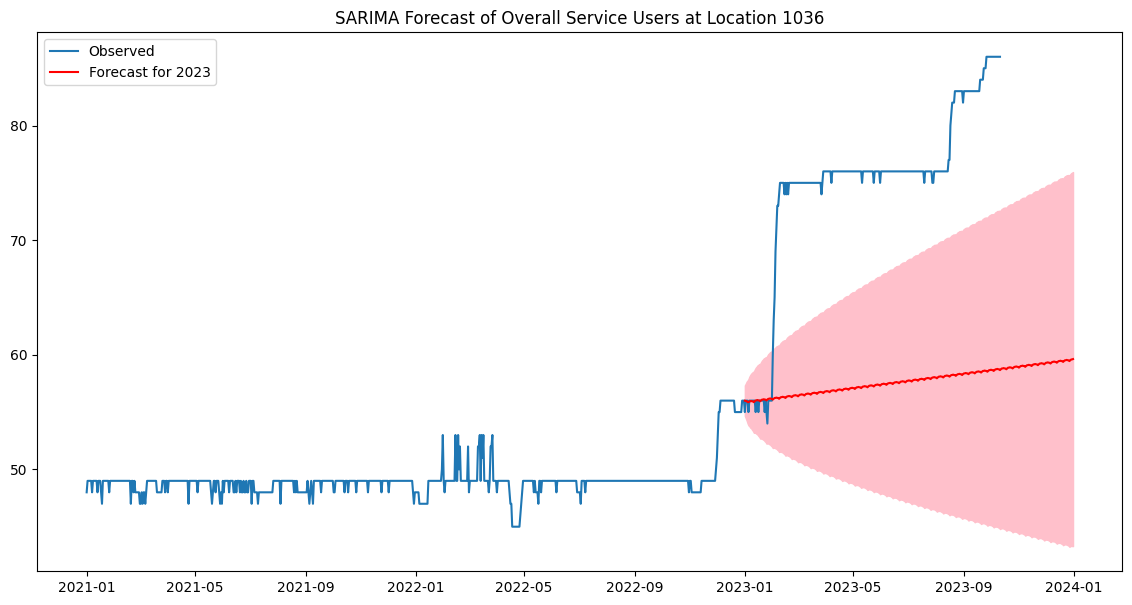

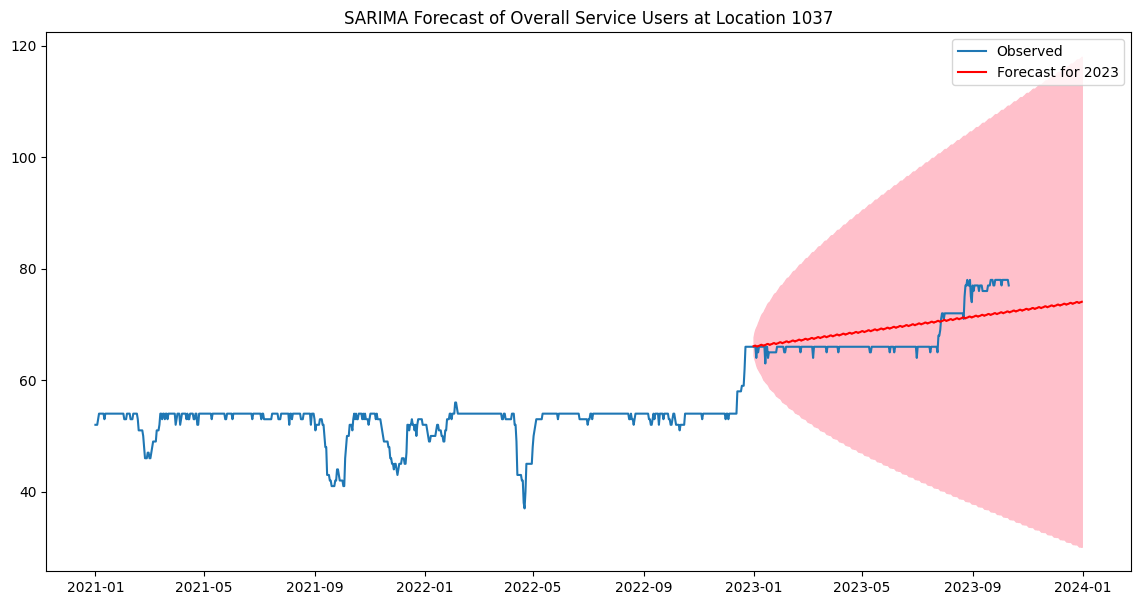

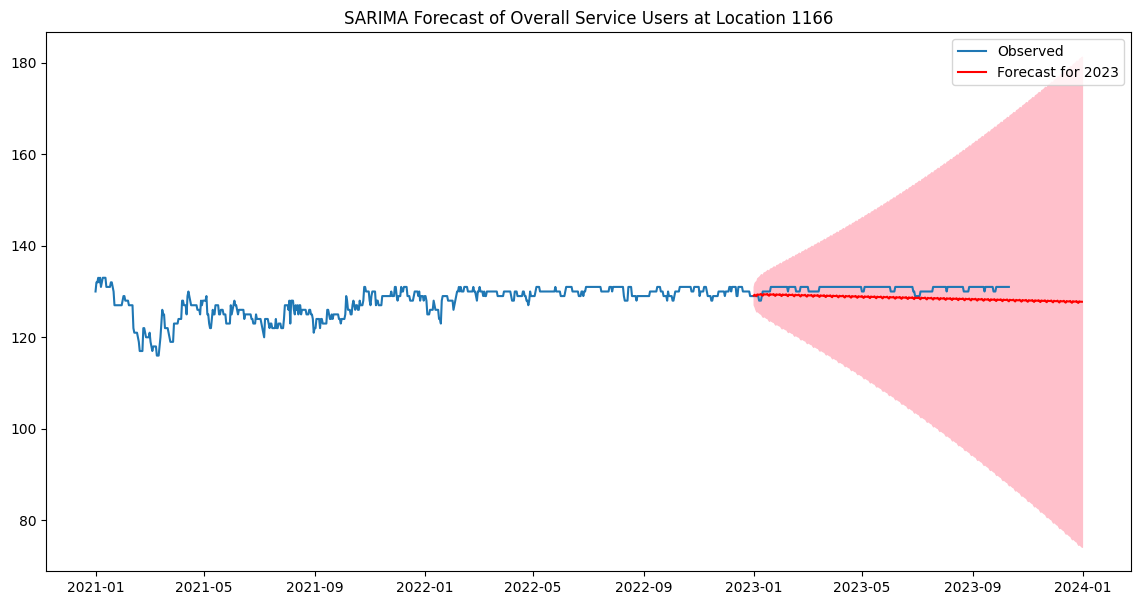

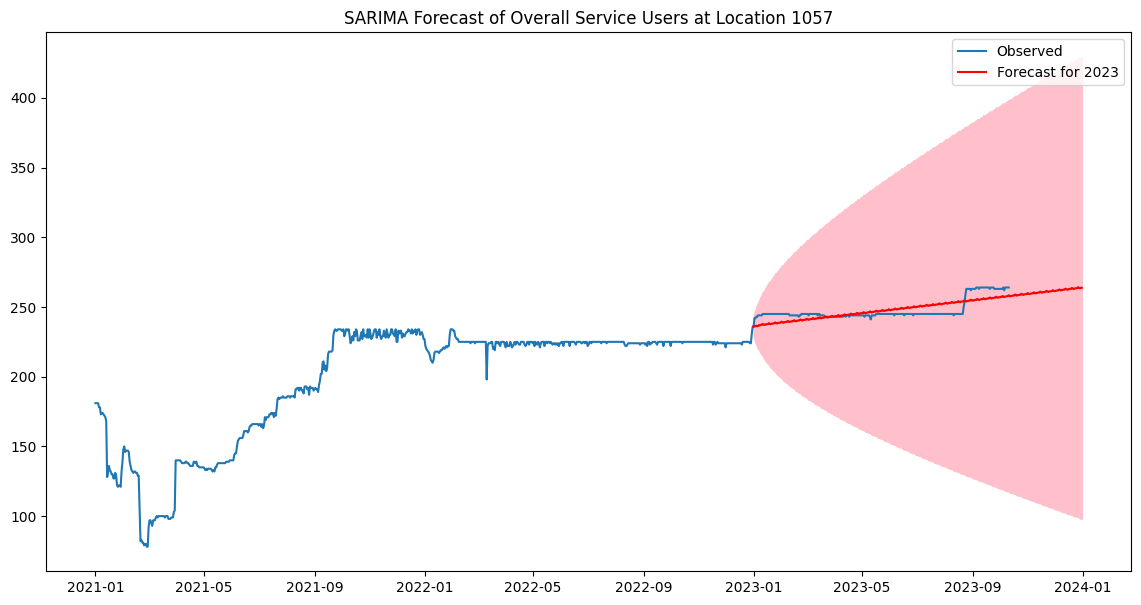

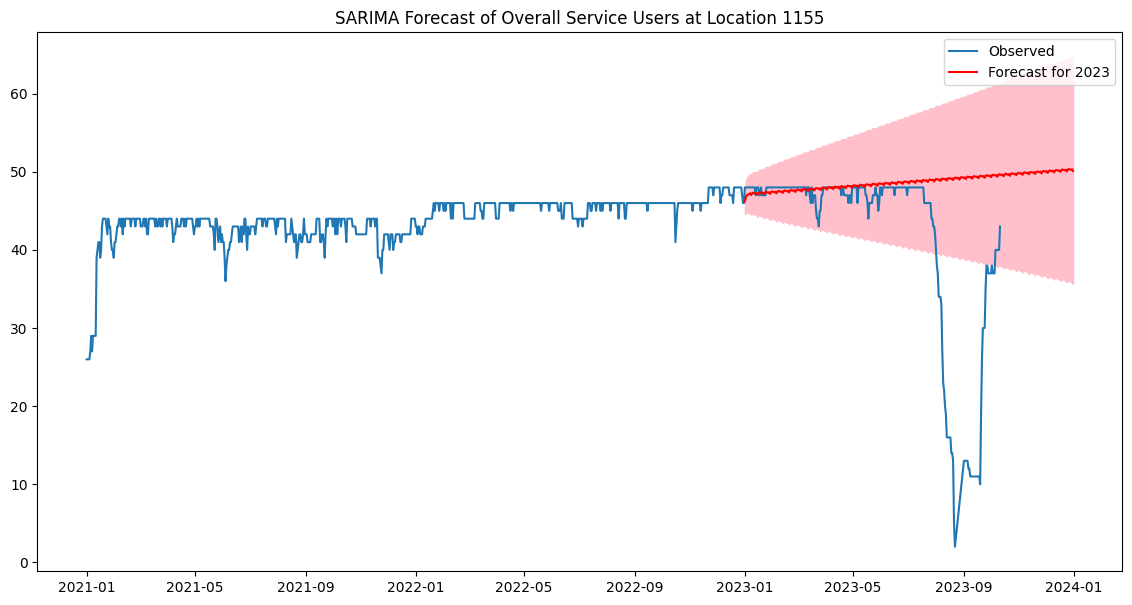

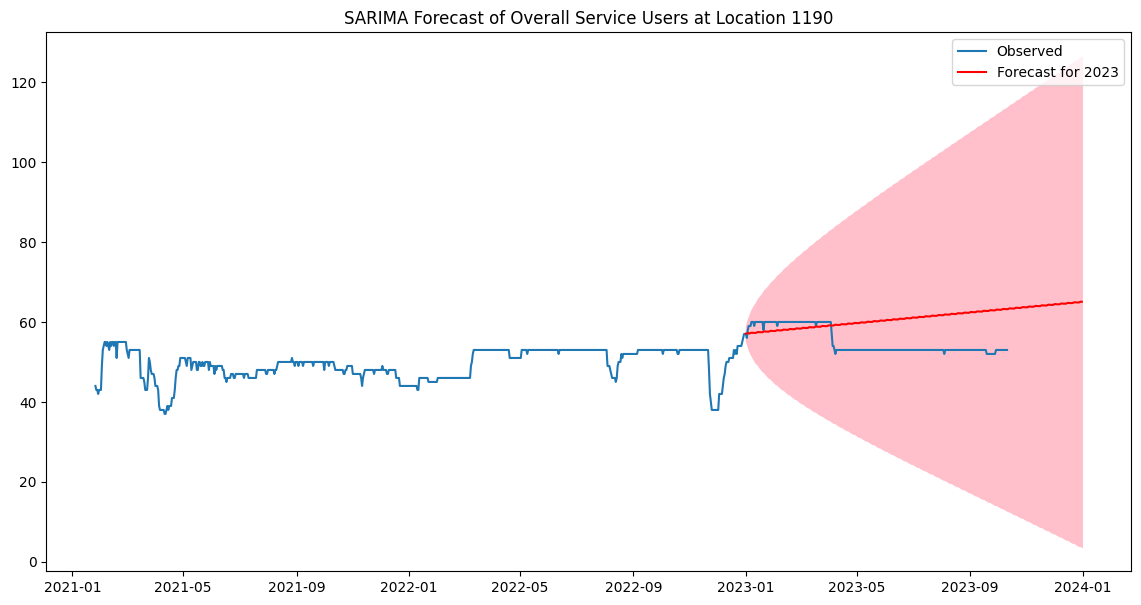

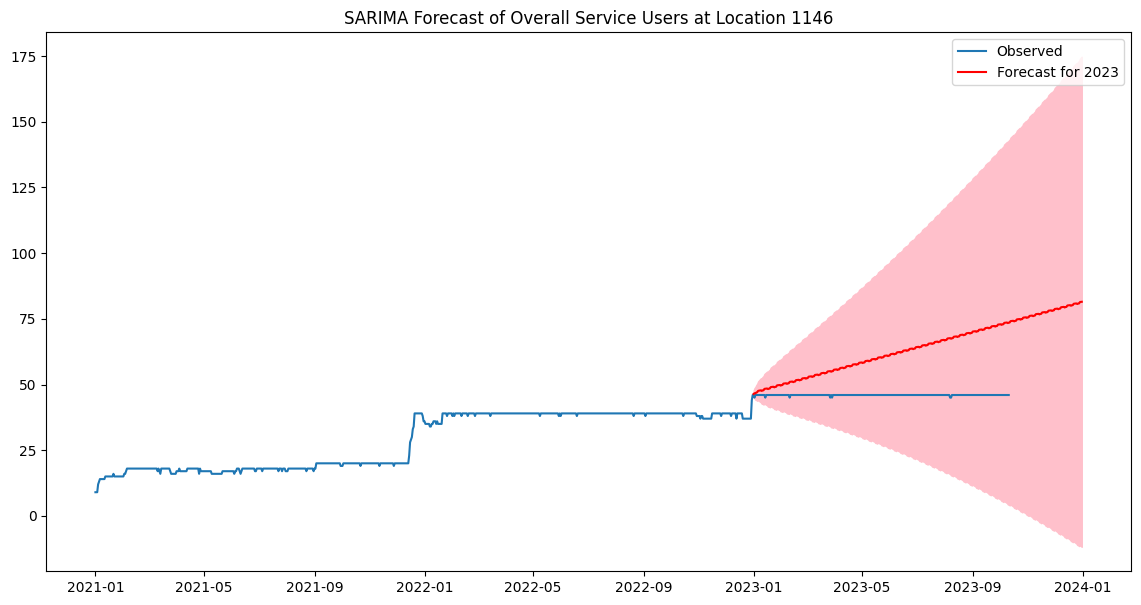

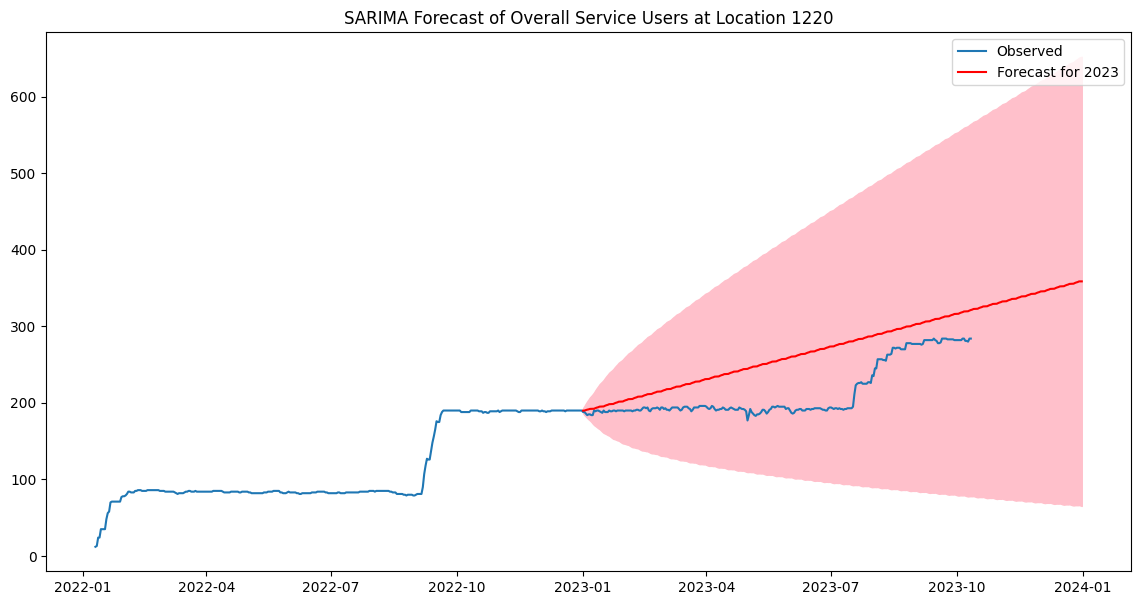

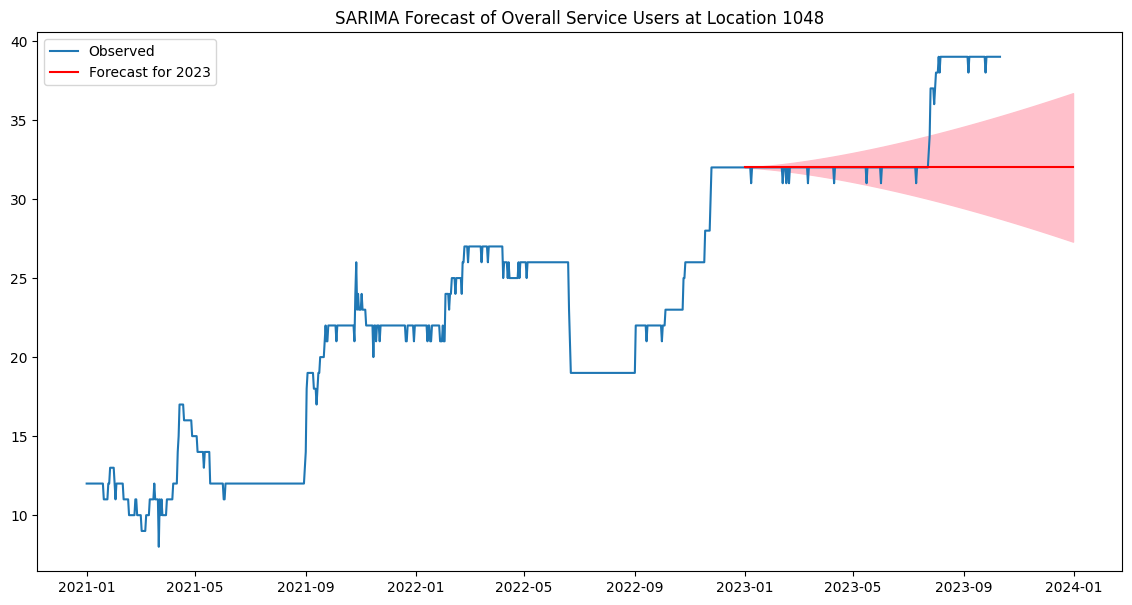

In [46]:
# Given DataFrame df and its column 'LOCATION_ID'
location_ids = df_filtered['LOCATION_ID'].unique()

# # List of location ids to remove - only one shelter
# # Currenly find those manually, is there a way to automate this?
remove_ids = [1066, 1067, 1011, 1163, 1026, 1149, 1015, 1055, 1152, 1108, 1150, 1125, 1031, 1033, 1002, 1126, 1115, 1001, 1171, 1052, 1029, 1192, 1198, 1007, 1240, 1158, 1147, 1300, 1320, 1360, 1004, 1118, 1019, 1400, 1078, 1189]

# Convert to numpy array for boolean indexing and remove NaN values and specified ids
location_ids = location_ids[~pd.isnull(location_ids)]
location_ids = location_ids[~np.isin(location_ids, remove_ids)]

# Save predicted values in dataframe
df1 = predict_per_location(location_ids[0]).to_frame()
df1.index.name = 'OCCUPANCY_DATE'
df1.reset_index(inplace=True)

df1['LOCATION_ID'] = location_ids[0]

for location_id in location_ids[1:]:
    d = predict_per_location(location_id).to_frame()
    d.index.name = 'OCCUPANCY_DATE'
    d.reset_index(inplace=True)
    
    d['LOCATION_ID'] = location_id
    df1 = pd.concat([df1, d])

df1['OCCUPANCY_DATE'] = pd.to_datetime(df1['OCCUPANCY_DATE'])

In [47]:
# Prepare dataframe of predicted values
combined_filtered_df['OCCUPANCY_DATE'] = pd.to_datetime(combined_filtered_df['OCCUPANCY_DATE'])
new_df = pd.merge(df1, combined_filtered_df,  how='inner', on=['LOCATION_ID', 'OCCUPANCY_DATE'])
new_df.rename(columns={"predicted_mean": "SERVICE_USER_COUNT_PRED"}, inplace=True)
new_df

,OCCUPANCY_DATE,SERVICE_USER_COUNT_PRED,LOCATION_ID,SERVICE_USER_COUNT
0,2023-01-01,465.378120,1114.0,462
1,2023-01-02,466.261459,1114.0,466
2,2023-01-03,466.468888,1114.0,460
3,2023-01-04,467.837457,1114.0,456
4,2023-01-05,468.390408,1114.0,459
...,...,...,...,...
9873,2023-10-07,32.000000,1048.0,39
9874,2023-10-08,32.000000,1048.0,39
9875,2023-10-09,32.000000,1048.0,39
9876,2023-10-10,32.000000,1048.0,39


In [48]:
# Check model accuracy
mse = mean_squared_error(new_df['SERVICE_USER_COUNT'], new_df['SERVICE_USER_COUNT_PRED'])
rmse = sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

mae = mean_absolute_error(new_df['SERVICE_USER_COUNT'], new_df['SERVICE_USER_COUNT_PRED'])
print(f'Mean Absolute Error: {mae}')

Root Mean Squared Error: 18.877293872841854
Mean Absolute Error: 9.345066819202486


In [49]:
# Save predicted values
new_df.to_csv("..\\outputs\\shelter_sarima.csv")